In [1]:
'''环境准备'''
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

'''挂载google硬盘'''
!mkdir -p drive
!google-drive-ocamlfuse drive

'''导入文件'''
from drive import *

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

初始训练集长度: 2324
初始测试集长度: 581
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=2712.545, BIC=2747.048, Fit time=3.131 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=3190.012, BIC=3201.513, Fit time=0.193 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=3159.654, BIC=3176.906, Fit time=0.201 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=3111.492, BIC=3128.744, Fit time=0.454 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=2732.240, BIC=2760.993, Fit time=1.403 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=2728.549, BIC=2768.803, Fit time=2.174 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2724.550, BIC=2753.303, Fit time=1.312 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=2714.195, BIC=2754.449, Fit time=4.059 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2796.228, BIC=2819.231, Fit time=1.244 seconds
Fit ARIMA:

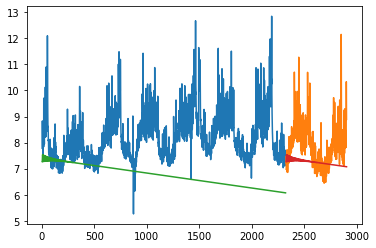

In [5]:
##########################################################  auto_arima ############################################################
import pandas as pd
import numpy as np
import seaborn as sns #热力图
import itertools 
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from statsmodels.tsa.stattools import adfuller #ADF检验
from statsmodels.stats.diagnostic import acorr_ljungbox #白噪声检验
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf #画图定阶
from statsmodels.tsa.arima_model import ARIMA #模型
from statsmodels.tsa.arima_model import ARMA #模型
from statsmodels.stats.stattools import durbin_watson #DW检验
from statsmodels.graphics.api import qqplot #qq图

#导入数据
data = pd.read_csv('/content/drive/jupyter/data/examples/example_wp_log_peyton_manning.csv', usecols=[1])

train_arima = data[:int(0.8*(len(data)))]
test_arima = data[int(0.8*(len(data))):]

print('初始训练集长度:',len(train_arima))
print('初始测试集长度:',len(test_arima))
look_back = 5

#安装包
!pip install pyramid-arima

#building the model
from pyramid.arima import auto_arima
model_autoarima = auto_arima(train_arima,trace=True,error_aciton='ignore',suppress_warnings=True)
model_autoarima.fit(train_arima)

pre_train_arima = model_autoarima.predict(n_periods=len(train_arima))
pre_train_arima = pd.DataFrame(pre_train_arima,index = train_arima.index,columns=['pre_train_arima']) 
pre_test_arima = model_autoarima.predict(n_periods=len(test_arima))
pre_test_arima = pd.DataFrame(pre_test_arima,index = test_arima.index,columns=['pre_test_arima'])
print('pre_test_arima类型：',type(pre_test_arima))
print('pre_test_arima:',pre_test_arima)

print('训练集预测长度为:',len(pre_train_arima))
print('测试集预测长度为:',len(pre_test_arima))

#calculate rmse
import math
from sklearn.metrics import mean_squared_error

train_arima = train_arima[look_back:len(train_arima)+1]
test_arima = test_arima[look_back:len(test_arima)+1]

print('截取的训练集长度为:',len(train_arima))
print('截取的测试集长度为:',len(test_arima))

pre_train_arima = pre_train_arima[look_back:len(train_arima)+look_back+1]
pre_test_arima = pre_test_arima[look_back:len(test_arima)+look_back+1]

print('截取的预测训练集长度为:',len(pre_train_arima))
print('截取的预测测试集长度为:',len(pre_test_arima))

train_rmse_arima = math.sqrt(mean_squared_error(train_arima,pre_train_arima)) 
test_rmse_arima = math.sqrt(mean_squared_error(test_arima,pre_test_arima))
print('train_rmse_arima:',train_rmse_arima)
print('test_rmse_arima:',test_rmse_arima)

#plot the predictions for validation set
plt.plot(train_arima, label='train_arima')
plt.plot(test_arima, label='test_arima')
plt.plot(pre_train_arima, label='pre_train_arima')
plt.plot(pre_test_arima, label='pre_test_arima')
plt.show()
print(model_autoarima.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 2324
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -1160.988
Date:                Sat, 25 Jul 2020   AIC                           2345.976
Time:                        12:58:33   BIC                           2414.983
Sample:                             0   HQIC                          2371.123
                               - 2324                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0006      0.003     -0.177      0.859      -0.007       0.006
ar.L1          1.1869      0.043     27.299      0.000       1.102       1.272
ar.L2         -1.7052      0.038    -44.350      0.000      -1.781      -1.630
ar.L3          1.3073      0.058     22.412      0.000       1.193       1.422
ar.L4         -1.2415      0.031    -39.551      0.000      -1.303      -1.180
ar.L5          0.3953      0.035     11.428      0.000       0.327       0.463
ma.L1         -1.5218      0.041    -37.020      0.000      -1.602      -1.441
ma.L2          1.8318      0.049     37.086      0.000       1.735       1.929
ma.L3         -1.6211      0.056    -28.704      0.000      -1.732      -1.510
ma.L4          1.2624      0.038     32.844      0.000       1.187       1.338
ma.L5         -0.6213      0.024    -25.604      0.000      -0.669      -0.574
sigma2         0.1587      0.002     64.553      0.000       0.154       0.164
===================================================================================
Ljung-Box (Q):                       68.19   Jarque-Bera (JB):              6515.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             1.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
########################################################## bayes-lstm ############################################################
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
# 数据不归一化，数据满足预设的训练和测试长度
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

look_back = 5
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

def lstm_error(look_back,first_unit,second_unit,epoch,batch_size): 
	import math
	look_back = math.floor(look_back)
	first_unit = math.floor(first_unit)
	second_unit = math.floor(second_unit)
	epoch = math.floor(epoch)
	batch_size = math.floor(batch_size)
	# fix random seed for reproducibility
	np.random.seed(7)

	# load the dataset
	dataframe = pd.read_csv('/content/drive/jupyter/data/examples/example_wp_log_peyton_manning.csv', usecols=[1])
	# dataframe = pd.read_excel('/content/drive/jupyter/data/swat/All.xlsx', usecols=[2])

	dataset = dataframe.values
	dataset = dataset.astype('float32')

	# split into train and test sets
	train_size = int(len(dataset) * 0.8)
	test_size = len(dataset) - train_size
	train_lstm, test_lstm = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

	# reshape into X=t and Y=t+1
	x_train_lstm, y_train_lstm = create_dataset(train_lstm, look_back)
	x_test_lstm, y_test_lstm = create_dataset(test_lstm, look_back)

	# reshape input to be [samples, time steps, features]
	x_train_lstm = np.reshape(x_train_lstm, (x_train_lstm.shape[0], x_train_lstm.shape[1], 1))
	x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], x_test_lstm.shape[1], 1))

	# print('y_test_lstm:',y_test_lstm)
	# print('type(y_test_lstm):',type(y_test_lstm))

	# create and fit the LSTM network
	model_lstm = Sequential()
	model_lstm.add(LSTM(first_unit, activation='relu',return_sequences=True,input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2])))
	model_lstm.add(LSTM(second_unit, activation='relu'))
	model_lstm.add(Dense(1))
	model_lstm.compile(loss='mean_squared_error', optimizer='adam')
	model_lstm.fit(x_train_lstm, y_train_lstm, nb_epoch=epoch, batch_size=batch_size, verbose=0)

	# make predictions
	pre_train_lstm = model_lstm.predict(x_train_lstm)
	pre_test_lstm = model_lstm.predict(x_test_lstm)

	# calculate root mean squared error
	train_rmse_lstm = math.sqrt(mean_squared_error(y_train_lstm, pre_train_lstm[:,0]))
	print('train_rmse_lstm: %.2f' % (train_rmse_lstm))
	test_rmse_lstm = math.sqrt(mean_squared_error(y_test_lstm, pre_test_lstm[:,0]))
	print('test_rmse_lstm: %.2f' % (test_rmse_lstm))
	return -test_rmse_lstm

lstm_op = BayesianOptimization(
		lstm_error,
		{
				'look_back':(5),
				'first_unit':(32,256),
				'second_unit':(32,256),
				'epoch':(50,200),
				'batch_size':(1,20)
		}
)

lstm_op.maximize()
print(lstm_op.max)

#总结最优参数，为传入模型做准备
lstm_look_back = math.floor(lstm_op.max['params']['look_back'])
lstm_first_unit = math.floor(lstm_op.max['params']['first_unit'])
lstm_second_unit = math.floor(lstm_op.max['params']['second_unit'])
lstm_epoch = math.floor(lstm_op.max['params']['epoch'])
lstm_batch_size = math.floor(lstm_op.max['params']['batch_size'])

# fix random seed for reproducibility
np.random.seed(7)

# load the dataset
dataframe = pd.read_csv('/content/drive/jupyter/data/examples/example_wp_log_peyton_manning.csv', usecols=[1])
# dataframe = pd.read_excel('/content/drive/jupyter/data/swat/All.xlsx', usecols=[2])

dataset = dataframe.values
dataset = dataset.astype('float32')

# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_lstm, test_lstm = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
x_train_lstm, y_train_lstm = create_dataset(train_lstm, lstm_look_back)
x_test_lstm, y_test_lstm = create_dataset(test_lstm, lstm_look_back)

# reshape input to be [samples, time steps, features]
x_train_lstm = np.reshape(x_train_lstm, (x_train_lstm.shape[0], x_train_lstm.shape[1], 1))
x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], x_test_lstm.shape[1], 1))

# print('y_test_lstm:',y_test_lstm)
# print('type(y_test_lstm):',type(y_test_lstm))

# create and fit the LSTM network
model_lstm = Sequential()
model_lstm.add(LSTM(lstm_first_unit, activation='relu',return_sequences=True,input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2])))
model_lstm.add(LSTM(lstm_second_unit, activation='relu'))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(x_train_lstm, y_train_lstm, nb_epoch=lstm_epoch, batch_size=lstm_batch_size, verbose=0)

# make predictions
pre_train_lstm = model_lstm.predict(x_train_lstm)
pre_test_lstm = model_lstm.predict(x_test_lstm)

# calculate root mean squared error
train_rmse_lstm = math.sqrt(mean_squared_error(y_train_lstm, pre_train_lstm[:,0]))
test_rmse_lstm = math.sqrt(mean_squared_error(y_test_lstm, pre_test_lstm[:,0]))
print('train_rmse_lstm: %.2f' % (train_rmse_lstm))
print('test_rmse_lstm: %.2f' % (test_rmse_lstm))

In [ ]:
##########################################################  bayes-fbprophet ############################################################
!pip install bayesian-optimization
import pandas as pd
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
import math
import numpy as np


def fb_error(look_back,changepoint_range,changepoint_prior_scale,yearly_seasonality,holidays_prior_scale):
  #获取数据(修改对应的列数)
  look_back = math.floor(look_back)
  holidays_prior_scale = math.floor(holidays_prior_scale)
  df = pd.read_csv('/content/drive/jupyter/data/examples/example_wp_log_peyton_manning.csv')
  # df = pd.read_excel('/content/drive/jupyter/data/swat/All.xlsx')
  colname = df.columns.values.tolist()
  # df = df[[colname[0],colname[2]]]
  # df = df.rename(columns={colname[0]: "ds", colname[2]: "y"})
  # print(len(df))
  train_size =  int(len(df) * 0.8)
  test_size = len(df) - train_size
  # print(train_size,test_size)
  fb_train = df[:train_size]
  fb_test = df[train_size:]
  # print(fb_train)
  # print(fb_test)

  #设置节假日
  playoffs = pd.DataFrame({
    'holiday': 'playoff',
    'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16','2010-01-24', '2010-02-07', '2011-01-08','2013-01-12', '2014-01-12', '2014-01-19',
                          '2014-02-02', '2015-01-11', '2016-01-17','2016-01-24', '2016-02-07']),
    'lower_window': 0,
    'upper_window': 1,
  })
  superbowls = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
    'lower_window': 0,
    'upper_window': 1,
  })
  holidays = pd.concat((playoffs, superbowls))

  #拟合模型
  m = Prophet(changepoint_range=changepoint_range,
          changepoint_prior_scale=changepoint_prior_scale,
          yearly_seasonality=yearly_seasonality,
          holidays_prior_scale=holidays_prior_scale)
  m.fit(fb_train)

  #设定预测长度
  future = m.make_future_dataframe(periods = test_size)

  #预测数据
  forecast = m.predict(future)
  forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

  #展示预测效果
  # m.plot(forecast)

  pre_train_fb = forecast.yhat[look_back:train_size].values.tolist()
  pre_test_fb = forecast.yhat[train_size+look_back:].values.tolist()

  y_train_fb = df.y[look_back:train_size].values.tolist()
  y_test_fb = df.y[train_size+look_back:].values.tolist()

  fb_train_rmse = np.sqrt(mean_squared_error(pre_train_fb,y_train_fb))
  fb_test_rmse = np.sqrt(mean_squared_error(pre_test_fb,y_test_fb))
  print('fb_train_rmse:',fb_train_rmse)
  print('fb_test_rmse:',fb_test_rmse)
  return -fb_test_rmse

fb_op = BayesianOptimization(
    fb_error,
    {
        'look_back':(5,10),
        'changepoint_range':(0.5,0.9),       #默认0.8
        'changepoint_prior_scale':(0.001,0.5),   #默认0.05
        'yearly_seasonality':(5,20),         #默认10
        'holidays_prior_scale':(5,20)        #默认10
    }
)

fb_op.maximize()
print(fb_op.max)

#获取数据(修改对应的列数)
look_back = 5
fb_look_back = math.floor(fb_op.max['params']['look_back'])
fb_changepoint_range = fb_op.max['params']['changepoint_range']
fb_changepoint_prior_scale = fb_op.max['params']['changepoint_prior_scale']
fb_yearly_seasonality = fb_op.max['params']['yearly_seasonality']
fb_holidays_prior_scale = math.floor(fb_op.max['params']['holidays_prior_scale'])

df = pd.read_csv('/content/drive/jupyter/data/examples/example_wp_log_peyton_manning.csv')
# df = pd.read_excel('/content/drive/jupyter/data/swat/All.xlsx')
colname = df.columns.values.tolist()
# df = df[[colname[0],colname[2]]]
# df = df.rename(columns={colname[0]: "ds", colname[2]: "y"})
# print(len(df))
train_size =  int(len(df) * 0.8)
test_size = len(df) - train_size
# print(train_size,test_size)
fb_train = df[:train_size]
fb_test = df[train_size:]
# print(fb_train)
# print(fb_test)

#设置节假日
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16','2010-01-24', '2010-02-07', '2011-01-08','2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17','2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

#拟合模型
m = Prophet(changepoint_range=fb_changepoint_range,
        changepoint_prior_scale=fb_changepoint_prior_scale,
        yearly_seasonality=fb_yearly_seasonality,
        holidays_prior_scale=fb_holidays_prior_scale)
m.fit(fb_train)

#设定预测长度
future = m.make_future_dataframe(periods = test_size)

#预测数据
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

#展示预测效果
# m.plot(forecast)

pre_train_fb = forecast.yhat[look_back:train_size].values.tolist()
pre_test_fb = forecast.yhat[train_size+look_back:].values.tolist()

y_train_fb = df.y[look_back:train_size].values.tolist()
y_test_fb = df.y[train_size+look_back:].values.tolist()

fb_train_rmse = np.sqrt(mean_squared_error(pre_train_fb,y_train_fb))
fb_test_rmse = np.sqrt(mean_squared_error(pre_test_fb,y_test_fb))
print('fb_train_rmse: %.2f',fb_train_rmse)
print('fb_test_rmse: %.2f',fb_test_rmse)

In [7]:
#获取数据(修改对应的列数)
look_back = 5
fb_look_back = math.floor(fb_op.max['params']['look_back'])
fb_changepoint_range = fb_op.max['params']['changepoint_range']
fb_changepoint_prior_scale = fb_op.max['params']['changepoint_prior_scale']
fb_yearly_seasonality = fb_op.max['params']['yearly_seasonality']
fb_holidays_prior_scale = math.floor(fb_op.max['params']['holidays_prior_scale'])

df = pd.read_csv('/content/drive/jupyter/data/examples/example_wp_log_peyton_manning.csv')
# df = pd.read_excel('/content/drive/jupyter/data/swat/All.xlsx')
colname = df.columns.values.tolist()
# df = df[[colname[0],colname[2]]]
# df = df.rename(columns={colname[0]: "ds", colname[2]: "y"})
# print(len(df))
train_size =  int(len(df) * 0.8)
test_size = len(df) - train_size
# print(train_size,test_size)
fb_train = df[:train_size]
fb_test = df[train_size:]
# print(fb_train)
# print(fb_test)

#设置节假日
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16','2010-01-24', '2010-02-07', '2011-01-08','2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17','2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

#拟合模型
m = Prophet(changepoint_range=fb_changepoint_range,
        changepoint_prior_scale=fb_changepoint_prior_scale,
        yearly_seasonality=fb_yearly_seasonality,
        holidays_prior_scale=fb_holidays_prior_scale)
m.fit(fb_train)

#设定预测长度
future = m.make_future_dataframe(periods = test_size)

#预测数据
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

#展示预测效果
# m.plot(forecast)

pre_train_fb = forecast.yhat[look_back:train_size].values.tolist()
pre_test_fb = forecast.yhat[train_size+look_back:].values.tolist()

y_train_fb = df.y[look_back:train_size].values.tolist()
y_test_fb = df.y[train_size+look_back:].values.tolist()

fb_train_rmse = np.sqrt(mean_squared_error(pre_train_fb,y_train_fb))
fb_test_rmse = np.sqrt(mean_squared_error(pre_test_fb,y_test_fb))
print('fb_train_rmse: %.2f',fb_train_rmse)
print('fb_test_rmse: %.2f',fb_test_rmse)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


fb_train_rmse: %.2f 0.48680077659528015
fb_test_rmse: %.2f 0.5619220762623705


In [ ]:
############################################################## ensemble-linear #############################################################################
from sklearn import linear_model
import numpy as np
look_back = 5
#首次线性回归（lstm、fbprophet模型的预测值的线性回归）
reg1 = linear_model.LinearRegression()

x_train_ensemble_linear1 = [list(t) for t in zip(pre_train_lstm,pre_train_fb)]
x_test_ensemble_linear1 = [list(t) for t in zip(pre_test_lstm,pre_train_fb)]

y_train_ensemble_linear = y_train_lstm.tolist()
y_test_ensemble_linear = y_test_lstm.tolist()

reg1.fit(x_train_ensemble_linear1,y_train_ensemble_linear)
reg1.coef_

!pip install scipy == 0.18.1
pre_train_ensemble_linear1 = reg1.predict(x_train_ensemble_linear1)
pre_test_ensemble_linear1 = reg1.predict(x_test_ensemble_linear1)

train_ensemble_linear_rmse1 = np.sqrt(mean_squared_error(y_train_ensemble_linear,pre_train_ensemble_linear1))
test_ensemble_linear_rmse1 = np.sqrt(mean_squared_error(y_test_ensemble_linear,pre_test_ensemble_linear1))

print('train_ensemble_linear_rmse1:',train_ensemble_linear_rmse1)
print('test_ensemble_linear_rmse1:',test_ensemble_linear_rmse1)

#第二次线性回归（X、lstm、fbprophet模型的预测值的线性回归）
x_train_lstm_ensemble,y_train_lstm = create_dataset(train_lstm,look_back)
x_test_lstm_ensemble,y_test_lstm = create_dataset(test_lstm,look_back)

x_train_ensemble_linear2 = [list(t) for t in zip(x_train_ensemble_linear1.tolist(),pre_train_ensemble_linear1)]
x_test_ensemble_linear2 = [list(t) for t in zip(x_test_ensemble_linear1.tolist(),pre_test_ensemble_linear1)]

reg2.fit(x_train_ensemble_linear2,y_train_ensemble_linear)
reg2.coef_

pre_train_ensemble_linear2 = reg2.predict(x_train_ensemble_linear2)
pre_test_ensemble_linear2 = reg2.predict(x_test_ensemble_linear2)

train_ensemble_linear_rmse2 = np.sqrt(mean_squared_error(y_train_ensemble_linear,pre_train_ensemble_linear2))
test_ensemble_linear_rmse2 = np.sqrt(mean_squared_error(y_test_ensemble_linear,pre_test_ensemble_linear2))

print('train_ensemble_linear_rmse1:',train_ensemble_linear_rmse2)
print('test_ensemble_linear_rmse1:',test_ensemble_linear_rmse2)

In [ ]:
################################################################# fb做基础 lstm做修正  ####################################################
y_train_fb_lstm = np.array(y_train_fb) - np.array(pre_train_fb)
y_test_fb_lstm = np.array(y_test_fb) - np.array(pre_test_fb)

# 数据不归一化，数据满足预设的训练和测试长度
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

look_back = 5
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

def fb_add_lstm_error(first_unit,second_unit,epoch,batch_size):
  import math
  first_unit = math.floor(first_unit)
  second_unit = math.floor(second_unit)
  epoch = math.floor(epoch)
  batch_size = math.floor(batch_size)

  #fix random seed for reproducibility
  np.random.seed(7)

  # load the dataset
  dataframe = pd.read_csv('/content/drive/jupyter/data/examples/example_wp_log_peyton_manning.csv', usecols=[1])
  # dataframe = pd.read_excel('/content/drive/jupyter/data/swat/All.xlsx', usecols=[2])

  dataset = dataframe.values
  dataset = dataset.astype('float32')

  # split into train and test sets
  train_size = int(len(dataset) * 0.8)
  test_size = len(dataset) - train_size
  train_lstm, test_lstm = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

  # reshape into X=t and Y=t+1
  x_train_lstm, y_train_lstm = create_dataset(train_lstm, look_back)
  x_test_lstm, y_test_lstm = create_dataset(test_lstm, look_back)

  # reshape input to be [samples, time steps, features]
  x_train_lstm = np.reshape(x_train_lstm, (x_train_lstm.shape[0], x_train_lstm.shape[1], 1))
  x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], x_test_lstm.shape[1], 1))

  # print('y_test_lstm:',y_test_lstm)
  # print('type(y_test_lstm):',type(y_test_lstm))

  # create and fit the LSTM network
  model_lstm = Sequential()
  model_lstm.add(LSTM(first_unit, activation='relu',return_sequences=True,input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2])))
  model_lstm.add(LSTM(second_unit, activation='relu'))
  model_lstm.add(Dense(1))
  model_lstm.compile(loss='mean_squared_error', optimizer='adam')
  model_lstm.fit(x_train_lstm, y_train_fb_lstm, nb_epoch=epoch, batch_size=batch_size, verbose=2)

  # make predictions
  pre_train_lstm = model_lstm.predict(x_train_lstm)
  pre_test_lstm = model_lstm.predict(x_test_lstm)

  ######################## 以下变量均为1维（pre_test_lstm为2维，进行了降维处理）  #############################
  train_fb_add_lstm = pre_train_fb + pre_train_lstm
  test_fb_add_lstm = pre_test_fb + pre_test_lstm.flatten()
  train_rmse_fb_add_lstm = np.sqrt(mean_squared_error(train_fb_add_lstm,y_train_fb))
  test_rmse_fb_add_lstm = np.sqrt(mean_squared_error(test_fb_add_lstm,y_test_fb))
  print('train_rmse_fb_add_lstm:',train_rmse_fb_add_lstm)
  print('test_rmse_fb_add_lstm:',test_rmse_fb_add_lstm)
  return -test_rmse_fb_add_lstm

fb_add_lstm_op = BayesianOptimization(
    fb_add_lstm_op_error,
    {
        'first_unit':(32,256),
        'second_unit':(32,256),
        'epoch':(50,200),
        'batch_size':(1,20)
    }
)
fb_add_lstm_op.maximize()
print(fb_add_lstm_op.max)


In [15]:
################################################################# fb做基础 cnn-lstm做修正  ####################################################
y_train_fb_add_cnn_lstm = np.array(y_train_fb) - np.array(pre_train_fb)
y_test_fb_add_cnn_lstm = np.array(y_test_fb) - np.array(pre_test_fb)

# 数据不归一化，数据满足预设的训练和测试长度
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Flatten,TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.convolutional import Con1D
from keras.layers.convolutional import MaxPooling1D

look_back = 5
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

def fb_add_cnn_lstm(filters,unit,epochs,batch_size): 
  import math
  filters = math.floor(filters)
  unit = math.floor(unit)
  epochs = math.floor(epochs)
  batch_size = math.floor(batch_size)

  #fix random seed for reproducibility
  np.random.seed(7)

  # load the dataset
  dataframe = pd.read_csv('/content/drive/jupyter/data/examples/example_wp_log_peyton_manning.csv', usecols=[1])
  # dataframe = pd.read_excel('/content/drive/jupyter/data/swat/All.xlsx', usecols=[2])

  dataset = dataframe.values
  dataset = dataset.astype('float32')

  # split into train and test sets
  train_size = int(len(dataset) * 0.8)
  test_size = len(dataset) - train_size
  train_lstm, test_lstm = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

  # reshape into X=t and Y=t+1
  x_train_fbcnnlstm, y_train_fbcnnlstm = create_dataset(train_lstm, look_back)
  x_test_fbcnnlstm, y_test_fbcnnlstm = create_dataset(test_lstm, look_back)

  # reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
  n_features = 1
  n_seq = 1
  n_steps = 5
  x_train_fbcnnlstm = x_train_fbcnnlstm.reshape((x_train_fbcnnlstm.shape[0], n_seq, n_steps, n_features))
  x_test_fbcnnlstm = x_test_fbcnnlstm.reshape((x_test_fbcnnlstm.shape[0], n_seq, n_steps, n_features))

  # print('y_test_lstm:',y_test_lstm)
  # print('type(y_test_lstm):',type(y_test_lstm))

  # create and fit the LSTM network
  model_fbcnnlstm = Sequential()
  model_fbcnnlstm.add(TimeDistributed(Conv1D(filters=filters, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
  model_fbcnnlstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model_fbcnnlstm.add(TimeDistributed(Flatten()))
  model_fbcnnlstm.add(LSTM(unit, activation='relu'))
  model_fbcnnlstm.add(Dense(1))
  model_fbcnnlstm.compile(optimizer='adam', loss='mse')
  model_fbcnnlstm.fit(x_train_cnnlstm,y_train_cnnlstm,epochs=epochs,batch_size=batch_size,verbose = 2)

  # make predictions
  pre_train_fbcnnlstm = model_fbcnnlstm.predict(x_train_fbcnnlstm)
  pre_test_fbcnnlstm = model_fbcnnlstm.predict(x_test_fbcnnlstm)

  ######################## 以下变量均为1维（pre_test_lstm为2维，进行了降维处理）  #############################
  train_fb_add_cnn_lstm = pre_train_fb + pre_train_fbcnnlstm
  test_fb_add_cnn_lstm = pre_test_fb + pre_test_fbcnnlstm.flatten()
  train_rmse_fb_add_cnn_lstm = np.sqrt(mean_squared_error(train_fb_add_cnn_lstm,y_train_fb))
  test_rmse_fb_add_cnn_lstm = np.sqrt(mean_squared_error(test_fb_add_cnn_lstm,y_test_fb))
  print('train_rmse_fb_add_cnn_lstm:',train_rmse_fb_add_cnn_lstm)
  print('test_rmse_fb_add_cnn_lstm:',test_rmse_fb_add_cnn_lstm)
  return -test_rmse_fb_add_cnn_lstm

fb_add_cnn_lstm_op = BayesianOptimization(
    fb_add_cnn_lstm_error,
    {
        'filters':(16,128),
        'unit':(32,128),
        'epochs':(50,500),
        'batch_size':(1,10)
    }
)
fb_add_cnn_lstm_op.maximize()
print(fb_add_cnn_lstm.max)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning:

The `nb_epoch` argument in `fit` has been renamed `epochs`.



Epoch 1/1
 - 9s - loss: 0.2372


In [10]:
################################################################################### bayes-cnn ###########################################################################
# convert an array of values into a dataset matrix
import numpy as np
import numpy
import matplotlib.pyplot as plt
import pandas
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

def create_dataset(dataset, look_back):
  dataX, dataY = [], []
  look_back = math.floor(look_back)
  # print(look_back)
  for i in range(len(dataset)-look_back):
    a = dataset[i:i+look_back, 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)

def cnn_error(look_back,unit,epoch):
  look_back = math.floor(look_back)
  unit = math.floor(unit)
  epoch = math.floor(epoch)
  batch_size = math.floor(batch_size) 

  dataframe = pandas.read_csv('example_wp_log_peyton_manning.csv', usecols=[1])
  # dataframe = pandas.read_excel('/content/drive/jupyter/data/swat/All.xlsx', usecols=[2])
  dataset = dataframe.values
  dataset = dataset.astype('float32')
  
  # split into train and test sets
  train_size = int(len(dataset) * 0.8)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

  # reshape into X=t and Y=t+1
  x_train_cnn, y_train_cnn = create_dataset(train, look_back)
  x_test_cnn, y_test_cnn = create_dataset(test, look_back)

  n_features = 1
  x_train_cnn_model = x_train_cnn.reshape((x_train_cnn.shape[0], x_train_cnn.shape[1], n_features))

  # define model
  model = Sequential()
  model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(int(look_back), n_features)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(unit, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  # fit model
  model.fit(x_train_cnn_model, y_train_cnn, epochs=epoch, verbose=0)
  # demonstrate prediction
  # x_input = array([70, 80, 90])
  x_test_cnn_model = x_test_cnn.reshape((len(x_test_cnn), int(look_back), n_features))
  pre_train_cnn = model.predict(x_train_cnn_model,verbose=0)
  pre_test_cnn = model.predict(x_test_cnn_model, verbose=0)

  from sklearn.metrics import mean_squared_error
  train_rmse_cnn = np.sqrt(mean_squared_error(pre_train_cnn,y_train_cnn))
  test_rmse_cnn = np.sqrt(mean_squared_error(pre_test_cnn,y_test_cnn))
  print('train_rmse_cnn:',train_rmse_cnn)
  print('test_rmse_cnn:',test_rmse_cnn)
  return -test_rmse_cnn

#以下的四个属性，是参数的变化范围，你可以自己设定
cnn_op = BayesianOptimization(
        cnn_error,
        pbounds={
         'look_back': (5),
         'unit': (16,256),
         'epoch': (50,200)
         }
    )

opt.maximize()
print(cnn_op.max)

#提取最优参数
cnn_look_back = math.floor(cnn_op.max['params']['look_back'])
cnn_unit = math.floor(cnn_op.max['params']['unit'])
cnn_epoch = math.floor(cnn_op.max['params']['epoch'])

dataframe = pandas.read_csv('example_wp_log_peyton_manning.csv', usecols=[1])
# dataframe = pandas.read_excel('/content/drive/jupyter/data/swat/All.xlsx', usecols=[2])
dataset = dataframe.values
dataset = dataset.astype('float32')

# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
x_train_cnn, y_train_cnn = create_dataset(train, look_back)
x_test_cnn, y_test_cnn = create_dataset(test, look_back)

n_features = 1
x_train_cnn_model = x_train_cnn.reshape((x_train_cnn.shape[0], x_train_cnn.shape[1], n_features))

# define model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(int(look_back), n_features)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(unit, activation='relu'))
cnn_model.add(Dense(1))
cnn_model.compile(optimizer='adam', loss='mse')
# fit model
cnn_model.fit(x_train_cnn_model, y_train_cnn, epochs=epoch, verbose=0)
# demonstrate prediction
# x_input = array([70, 80, 90])
x_test_cnn_model = x_test_cnn.reshape((len(x_test_cnn), int(look_back), n_features))
pre_train_cnn = model.predict(x_train_cnn_model,verbose=0)
pre_test_cnn = model.predict(x_test_cnn_model, verbose=0)

from sklearn.metrics import mean_squared_error
train_rmse_cnn = np.sqrt(mean_squared_error(pre_train_cnn,y_train_cnn))
test_rmse_cnn = np.sqrt(mean_squared_error(pre_test_cnn,y_test_cnn))
print('train_rmse_cnn:',train_rmse_cnn)
print('test_rmse_cnn:',test_rmse_cnn)

{'target': -0.5427652714890532, 'params': {'changepoint_prior_scale': 0.10560102522562856, 'changepoint_range': 0.6567488216185153, 'holidays_prior_scale': 12.024153026998672, 'look_back': 4.955915494507302, 'yearly_seasonality': 16.00396642268028}}
<class 'dict'>
-0.5427652714890532
4.955915494507302
